In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph, plot_elbo
from libs.model_minibatch_series import HGPforecaster, PiecewiseLinearChangepoints
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import theano
theano.config.compute_test_value='raise'

In [2]:
data = pd.read_csv('../data/tourism_task2_to_r.csv')

data['t'] = data['Date'].astype('datetime64[ns]')
dates_ = data['t'].astype('datetime64[ns]')
data = data.drop('Date', axis=1)

data_pivot = data.pivot(index='t',columns=['state', 'zone', 'region', 'purpose'], values='Count')

groups_input = {
    'state': [0],
    'zone': [1],
    'region': [2],
    'purpose': [3]
}

groups = generate_groups_data_flat(y = data_pivot, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [3]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  piecewise_out=True,
                  changepoints = 4)

In [4]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 3.978e+06


Sampling...


In [5]:
m.predict()

Sampling...


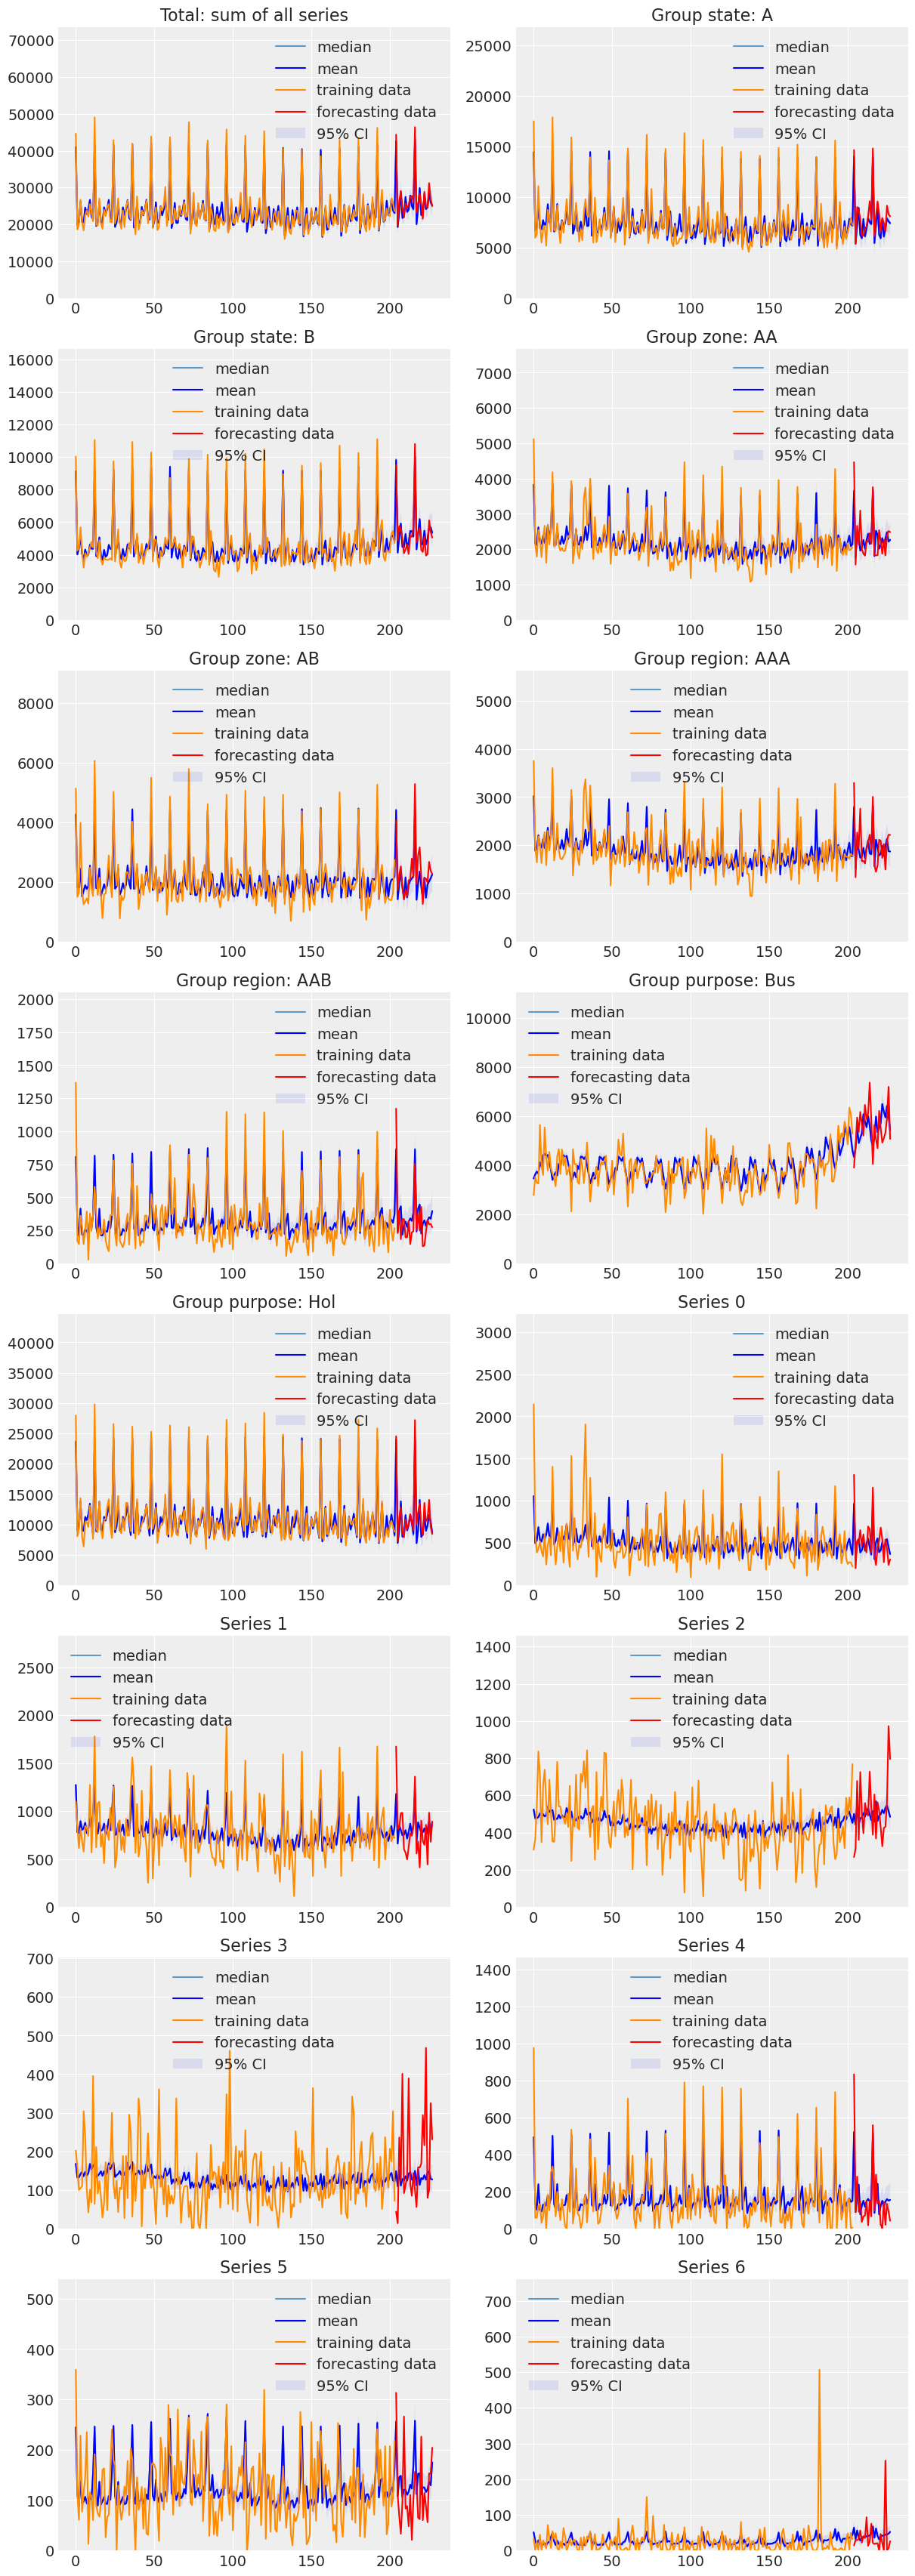

In [6]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [7]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

,bottom,total,state,zone,region,purpose,all
mase,0.93,0.844,0.915,0.95,0.898,0.85,0.929
rmse,52.456,1863.846,553.421,246.692,121.494,815.87,81.767


# StudentT Likelihood

In [3]:
data = pd.read_csv('../data/tourism_task2_to_r.csv')

data['t'] = data['Date'].astype('datetime64[ns]')
dates_ = data['t'].astype('datetime64[ns]')
data = data.drop('Date', axis=1)

data_pivot = data.pivot(index='t',columns=['state', 'zone', 'region', 'purpose'], values='Count')

groups_input = {
    'state': [0],
    'zone': [1],
    'region': [2],
    'purpose': [3]
}

groups = generate_groups_data_flat(y = data_pivot, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [4]:
import pymc3 as pm
import theano.tensor as tt
import theano
import numpy as np
from libs.pre_processing_minibatch_series import generate_groups_data_matrix_minibatch, generate_groups_data_matrix, data_transform

'''
Features:
1. The levels of the hierarchy that are used in the estimation 
    (i.e. considered to generate new gaussian processes) - 
    fewer levels don't use all the potential information 
    nested in the hierarchies but can boost performance
2. The seasonality to consider (i.e. the periodic 
    kernel defined for the cov function of the GP)
3. Option to define a piecewise function for the GP mean and respective
    selection of the number of changepoints - avoiding the need to apply 
    first differnece to the data
4. Possibility to define a piecewise function outside of the GPs and sum
    their values only in the likelihood
5. Option to use MAP or VI to estimate the parameter values (VI is advised 
    using normal likelihood)
6. Possibility to use Minibatch that ensures scalability of the model
7. Possibility to define a linear kernel to model the linear trend of the data
    avoiding the need to apply first difference to the data
8. Select only partial pooling on the piecewise function
'''

class Linear(pm.gp.mean.Mean):
    # This linear function with a log-link function results in an 
    # exponential mean 
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)


class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    # Piecewise linear function to be used as the mean function of the GPs
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints,
                 groups, 
                 minibatch):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def __call__(self, X):
        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))

        return (piecewise + self.a).reshape((-1,))


class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 a,
                 changepoints,
                 groups,
                 minibatch,
                 n_series,
                 predict=False):
        self.a = a
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch
        self.n_series = n_series.shape[0]
        self.predict = predict

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):

        if not self.minibatch or self.predict:
            # with minibatch, X is already a theano variable
            X = theano.shared(X)

        if self.predict:
            self.n_series = self.g['predict']['s']
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.n_series)) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise + self.a


class HGPforecaster:
    """HGP forecaster
    Parameters
    ----------
    groups_data: dict
                train
                predict
                    'groups_idx'
                    'groups_n'
                    'groups_names'
                    'n'
                    's'
                    'n_series_idx'
                    'n_series'
                    'g_number'
                    'data'
                seasonality
                horizon
    levels: list
                levels to be used in the estimation (default uses all levels)
    changepoints: int
                define a piecewise function as the mean of the GPs based on the number of 
                changepoints defined by the user (uniformly distributed across time)
    n_iterations: int
                number of iterations to run on the optimization (MAP or VI)
    minibatch: list[n_points, n_series]
                list with number of points and number of series to consider
    piecewise_out: bool
            possibility to define a piecewise linear function outside of the GPs definition. It will be summed 
            to the GPs output in the likelihood
    kernel_lin_mean: bool
            possibility to define a linear kernel to model the linear trend of the data avoiding the 
            need to apply first difference to the data
    partial_pool_mean: bool
            select partial pooling on the piecewise function. Defaul to true
    """
    def __init__(
        self,
        groups_data,
        levels=None,
        changepoints=None,
        n_iterations=10000,
        minibatch=None,
        piecewise_out = False,
        kernel_lin_mean=None,
        partial_pool_mean=True
    ):
        self.model = pm.Model()
        self.priors = {}
        self.g = groups_data
        self.y_pred = None
        self.mp = None
        self.gp_dict={}
        self.pred_samples_fit=None
        self.pred_samples_predict=None
        self.season = self.g['seasonality']
        self.n_iterations = n_iterations
        self.trace_vi = None
        self.pred_samples_fit = None
        self.trace_vi_samples = None
        self.piecewise_out = piecewise_out

        self.kernel_lin_mean = kernel_lin_mean
        self.partial_pool_mean = partial_pool_mean

        if changepoints:
            self.changepoints = np.linspace(0, self.g['train']['n'], changepoints+2)[1:-1]
        else:
            self.changepoints = np.array(())

        if levels:
            self.levels = levels
        else:
            self.levels = list(self.g['train']['groups_names'].keys())

        self.minibatch = minibatch
        self.series = None

        # transform the data to matrix form
        self.g = generate_groups_data_matrix(self.g)
        self.dt = data_transform(self.g)

        # if likelihood is normal standardize data
        self.g = self.dt.std_transf_train()

        # to use minibatch transform the arrays to minibatch tensors
        if self.minibatch:
            self.g, self.X_mi = generate_groups_data_matrix_minibatch(self.g, self.minibatch[0], self.minibatch[1])

        self.X = np.arange(self.g['train']['n']).reshape(-1,1)

    def generate_priors(self):
        """Set up the priors for the model."""
        with self.model:

            if self.minibatch:
                self.series = self.g['train']['n_series_idx'].eval()
            else:
                self.series = self.g['train']['n_series_idx']
            
            self.series_full = self.g['train']['n_series_idx_full']

            # In the case of a normal likelihood we need to define sigma
            self.priors['sigma'] = pm.HalfNormal(
                'sigma',
                0.001,
                shape = self.g['train']['s'])
            
            # In the case of a studentT likelihood we need to define nu
            self.priors['nu'] = pm.HalfNormal(
                'nu',
                0.01,
                shape = self.g['train']['s'])

            if self.piecewise_out:
                # Normal likelihood
                if self.partial_pool_mean:
                    for group in self.levels:
                        # priors for the group effects
                        # we want a partial pooling effect, so reduce the sd of the several parameters,
                        # while defining a wider hyperparameter

                        # Hyperprior for the mean
                        self.priors["mu_b_%s" %group] = pm.Normal(
                            "mu_b_%s" %group, 
                            mu=0.0, 
                            sd=0.01)
                        self.priors["mu_k_%s" %group] = pm.Normal(
                            'mu_k_%s' %group, 
                            0.0,
                            0.01)
                        self.priors["mu_m_%s" %group] = pm.Normal(
                            'mu_m_%s' %group, 
                            0.0,
                            0.01)
                        self.priors["mu_a_%s" %group] = pm.Normal(
                            'mu_a_%s' %group, 
                            0.0,
                            0.1)                          
                        # Hyperprior for the std
                        self.priors["sd_b_%s" %group] = pm.HalfNormal(
                            "sd_b_%s" %group, 
                            sd=0.01)
                        self.priors["sd_k_%s" %group] = pm.HalfNormal(
                            'sd_k_%s' %group, 
                            0.01)
                        self.priors["sd_m_%s" %group] = pm.HalfNormal(
                            'sd_m_%s' %group, 
                            0.01)
                        self.priors["sd_a_%s" %group] = pm.HalfNormal(
                            'sd_a_%s' %group, 
                            0.01)                                   

                        # Partially pooled parameters
                        self.priors["b_%s" %group] = pm.Normal(
                            "b_%s" %group, 
                            self.priors["mu_b_%s" %group], 
                            self.priors["sd_b_%s" %group],
                            shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            "k_%s" %group, 
                            self.priors["mu_k_%s" %group], 
                            self.priors["sd_k_%s" %group],
                            shape=self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            "m_%s" %group, 
                            self.priors["mu_m_%s" %group], 
                            self.priors["sd_m_%s" %group],
                            shape=self.g['train']['groups_n'][group])
                        self.priors["a_%s" %group] = pm.Normal(
                            "a_%s" %group, 
                            self.priors["mu_a_%s" %group], 
                            self.priors["sd_a_%s" %group],
                            shape=self.g['train']['groups_n'][group])
                else:
                    self.priors["k"] = pm.Normal(
                        'k',
                        0.0,
                        0.01,
                        shape = self.g['train']['s'])
                    self.priors["m"] = pm.Normal(
                        'm', 
                        0.0,
                        0.01,
                        shape = self.g['train']['s'])
                    self.priors["b"] = pm.Normal(
                        'b', 
                        0.,
                        0.01,
                        shape = (self.changepoints.shape[0], self.g['train']['s']))                        

            # prior for the periodic kernel (seasonality)
            self.priors["period"] = pm.Laplace(
                    "period", self.season, 0.1)

            for group in self.levels:

                # priors for the kernels of each group

                # The inverse gamma is very useful to inform our prior dist of the length scale
                # because it supresses both zero and infinity.
                # The data don't inform length scales larger than the maximum covariate distance 
                # and shorter than the minimum covariate distance (distance between time points which 
                # is always 1 in our case).

                # Parameters expQuad kernel
                self.priors["l_t_%s" %group] = pm.InverseGamma(
                    'l_t_%s' %group, 
                    4, 
                    self.g['train']['n'], 
                    shape = self.g['train']['groups_n'][group])
                self.priors["eta_t_%s" %group] = pm.HalfNormal(
                    'eta_t_%s' %group, 
                    1,
                    shape = self.g['train']['groups_n'][group])

                # Parameters periodic kernel
                self.priors["l_p_%s" %group] = pm.HalfNormal(
                    'l_p_%s' %group, 
                    0.5,
                    shape = self.g['train']['groups_n'][group])
                self.priors["eta_p_%s" %group] = pm.HalfNormal(
                    'eta_p_%s' %group, 
                    1.5, 
                    shape = self.g['train']['groups_n'][group])

                # Parameters white noise kernel
                self.priors["sigma_%s" %group] = pm.HalfNormal(
                    'sigma_%s' %group, 
                    0.001,
                    shape = self.g['train']['groups_n'][group])

                if self.piecewise_out:
                    # If piecewise_out is true the piecewise function is defined outside
                    # of the Gaussian processes, therefore nothing is done here
                    pass
                elif np.any(self.changepoints):
                    if self.partial_pool_mean:
                        # Parameters for the piecewise linear function defined as GPs mean functions
                        # with a normal likelihood -> wider intervals as we don't have the log-link
                        # function
                        self.priors["hy_b_%s" %group] = pm.Normal(
                            "hy_b_%s" %group, 
                            mu=0.0, 
                            sd=0.1)
                        self.priors["hy_k_%s" %group] = pm.Normal(
                            'hy_k_%s' %group, 
                            0.0,
                            0.1)
                        self.priors["hy_m_%s" %group] = pm.Normal(
                            'hy_m_%s' %group, 
                            0.0,
                            0.1)                            
                        # priors for the group effects
                        # we want a partial pooling effect, so reduce the sd of the several parameters,
                        # while defining a wider hyperparameter
                        # Partially pooled parameters
                        self.priors["b_%s" %group] = pm.Normal(
                            "b_%s" %group, 
                            self.priors["hy_b_%s" %group], 
                            0.01,
                            shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            "k_%s" %group, 
                            self.priors["hy_k_%s" %group], 
                            0.01,
                            shape=self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            "m_%s" %group, 
                            self.priors["hy_m_%s" %group], 
                            0.01,
                            shape=self.g['train']['groups_n'][group])
                    else:
                        # Parameters for the piecewise linear function defined as GPs mean functions
                        # with a normal likelihood -> wider intervals as we don't have the log-link
                        # function
                        self.priors["b_%s" %group] = pm.Normal(
                            'b_%s' %group, 
                            0.0,
                            0.05,
                            shape = (self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            'k_%s' %group, 
                            0.0,
                            0.1,
                            shape = self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            'm_%s' %group, 
                            0.0,
                            0.1,
                            shape = self.g['train']['groups_n'][group])
                elif self.kernel_lin_mean:
                    # Parameters linear kernel to model the mean of the GP
                    self.priors["c_%s" %group] = pm.Normal(
                        'c_%s' %group, 
                        0, 
                        0.1,
                        shape = self.g['train']['groups_n'][group])
                    self.priors["sigma_l_%s" %group] = pm.HalfNormal(
                        'sigma_l_%s' %group, 
                        1,
                        shape = self.g['train']['groups_n'][group])


    def generate_GPs(self):
        self.generate_priors()
        
        gp_dict = {}
        f_dict = {}
        f_flat = {}
        idx_dict = {}
        
        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['train']['groups_names'][group]):

                    # mean function for the GP with specific parameters per group

                    if self.piecewise_out:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    elif np.any(self.changepoints):
                        mu_func = PiecewiseLinearChangepoints(intercept = np.zeros(1),
                                                              b = self.priors["b_%s" %group][:, idx],
                                                              changepoints = self.changepoints,
                                                              k = self.priors["k_%s" %group][idx],
                                                              m = self.priors["m_%s" %group][idx],
                                                              groups = self.g,
                                                              minibatch = self.minibatch)

                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])                                
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    elif self.kernel_lin_mean:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + self.priors["sigma_l_%s" %group][idx]**2 * pm.gp.cov.Linear(1, c=self.priors["c_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    else:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    if self.minibatch:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group].eval()==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True, shape = self.minibatch[0])
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))
                    else:
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group]==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True)
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))

            self.f = sum(f_flat.values())
        
    def likelihood_fn(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            # Using minibatch
            with self.model:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g,
                                                        minibatch = self.minibatch,
                                                        n_series = self.series).build(self.X)
                    
                    piece = sum(piece_.values())
                    self.y_pred = pm.Normal('y_pred', 
                        nu=self.priors['nu'][self.series].reshape((1,-1)),
                        mu=self.f + piece, 
                        sd=self.priors['sigma'][self.series].reshape((1,-1)),
                        observed=self.g['train']['data'],
                        total_size=(self.g['train']['n'],self.g['train']['s']))
                else:
                    # defining a normal likelihood with minibatch
                    self.y_pred = pm.StudentT('y_pred',
                                nu=self.priors['nu'][self.series].reshape((1,-1)),
                                mu=self.f,
                                sd=self.priors['sigma'][self.series].reshape((1,-1)),
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))

        else:
            # Not using minibatch
            with self.model:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g,
                                                        minibatch = self.minibatch,
                                                        n_series = self.series).build(self.X)
                    
                    piece = sum(piece_.values())
                    self.y_pred = pm.StudentT('y_pred', 
                        nu=self.priors['nu'][self.series].reshape((1,-1)),
                        mu=self.f + piece, 
                        sd=self.priors['sigma'],
                        observed=self.g['train']['data'])
                else:
                    # normal likelihood without minibatch
                    self.y_pred = pm.StudentT('y_pred',
                            nu=self.priors['nu'][self.series].reshape((1,-1)),
                            mu=self.f,
                            sd=self.priors['sigma'],
                            observed=self.g['train']['data'])


    def prior_predictive_checks(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            raise NotImplementedError("Please do your prior predictive checks without using minibatch")

        with self.model:
            if self.piecewise_out:
                # normal likelihood with a piecewise function summed
                piece_={}
                for group in self.levels:
                    piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                    m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                    b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                    a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                    changepoints = self.changepoints,
                                                    groups = self.g,
                                                    minibatch = self.minibatch,
                                                    n_series = self.series).build(self.X)

                piece = sum(piece_.values())
                self.prior_like = pm.Normal('prior_like', 
                    mu=piece + self.f, 
                    sd=self.priors['sigma'],
                    shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))

            self.prior_checks = pm.sample_prior_predictive(200)

    def fit_map(self):
        self.likelihood_fn()

        if self.minibatch:
            raise ValueError('Cannot use MAP with minibatch. Please call the `fit_vi` method.')

        with self.model:
            print('Fitting model...')
            self.mp = pm.find_MAP(maxeval=self.n_iterations)
            print('Sampling...')
            self.pred_samples_fit = pm.sample_posterior_predictive([self.mp], 
                                                    vars=[self.y_pred], 
                                                    samples=500)
            
    def fit_vi(self):
        self.likelihood_fn()
        with self.model:
            print('Fitting model...')
            self.trace_vi = pm.fit(self.n_iterations,
                                   method='advi',
                                   # Stochastic nature of VI in PyMC3. In PyMC3, VI uses MC sample to approximate the objective gradients. 
                                   # As a consequence, the result of the fit is stochastic - you can see that in the ELBO it is not always decreasing. 
                                   # So when you stop the training, VI return the fitting from the last iteration, which can happen to have high ELBO. 
                                   # Solution is to increase the obj_n_mc - Number of monte carlo samples used for approximation of objective gradients. 
                                   obj_n_mc=1,
                                   obj_optimizer=pm.adamax(),
                                   # Defining a callback to do early stop when convergence is achieved
                                   callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)])
            print('Sampling...')
            self.trace_vi_samples = self.trace_vi.sample()
            self.pred_samples_fit = pm.sample_posterior_predictive(self.trace_vi_samples,
                                                                   vars=[self.y_pred],
                                                                   samples=500)
    
        if not self.minibatch:
            # with minibatch there is no possibility to recover the fitted values
            # backtransform the sampling of the fit for the original scale
            self.pred_samples_fit = self.dt.inv_transf_train_general(self.pred_samples_fit['y_pred'])


    def predict(self):
        f_new = {}
        f_flat_new = {}
        idx_dict_new = {}

        n_new = self.g['predict']['n']
        X_new = np.arange(n_new).reshape(-1,1)

        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['predict']['groups_names'][group]):
                    idx_dict_new[name] = np.where(self.g['predict']['groups_idx'][group]==idx,1,0)
                    f_new[name] = self.gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
                    f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

            f_ = sum(f_flat_new.values())

            if self.piecewise_out:
                piece_={}
                for group in self.levels:
                    piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['predict']['groups_idx'][group]],
                                                    m = self.priors["m_%s" %group][self.g['predict']['groups_idx'][group]],
                                                    b = self.priors['b_%s' %group][:,self.g['predict']['groups_idx'][group]],
                                                    a = self.priors["a_%s" %group][self.g['predict']['groups_idx'][group]],
                                                    changepoints = self.changepoints,
                                                    groups = self.g,
                                                    minibatch = self.minibatch,
                                                    n_series = self.series,
                                                    predict=True).build(X_new)

                piece = sum(piece_.values())
                y_pred_new = pm.StudentT("y_pred_new",
                                nu=self.priors['nu'],
                                mu=f_ + piece,
                                sd=self.priors['sigma'],
                                shape=(n_new, self.g['predict']['s']))
            else:
                y_pred_new = pm.StudentT("y_pred_new",
                                nu=self.priors['nu'],
                                mu=f_, 
                                sd=self.priors['sigma'],
                                shape=(n_new, self.g['predict']['s']))
            print('Sampling...')
            if self.trace_vi_samples:
                # Sampling using trace from VI
                self.pred_samples_predict = pm.sample_posterior_predictive(self.trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=500)
            else:
                # Sampling using points from MAP
                self.pred_samples_predict = pm.sample_posterior_predictive([self.mp], 
                              vars=[y_pred_new], 
                              samples=500)

        # backtransform the data and predictions to the original scale
        if self.minibatch:   
            self.g['train']['data'] = self.g['train']['full_data'] 
            self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])
        else:
            self.g = self.dt.inv_transf_train()
            self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])

In [5]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  piecewise_out=True,
                  changepoints = 4)

In [6]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 3.3481e+05


Sampling...


In [7]:
m.predict()

Sampling...


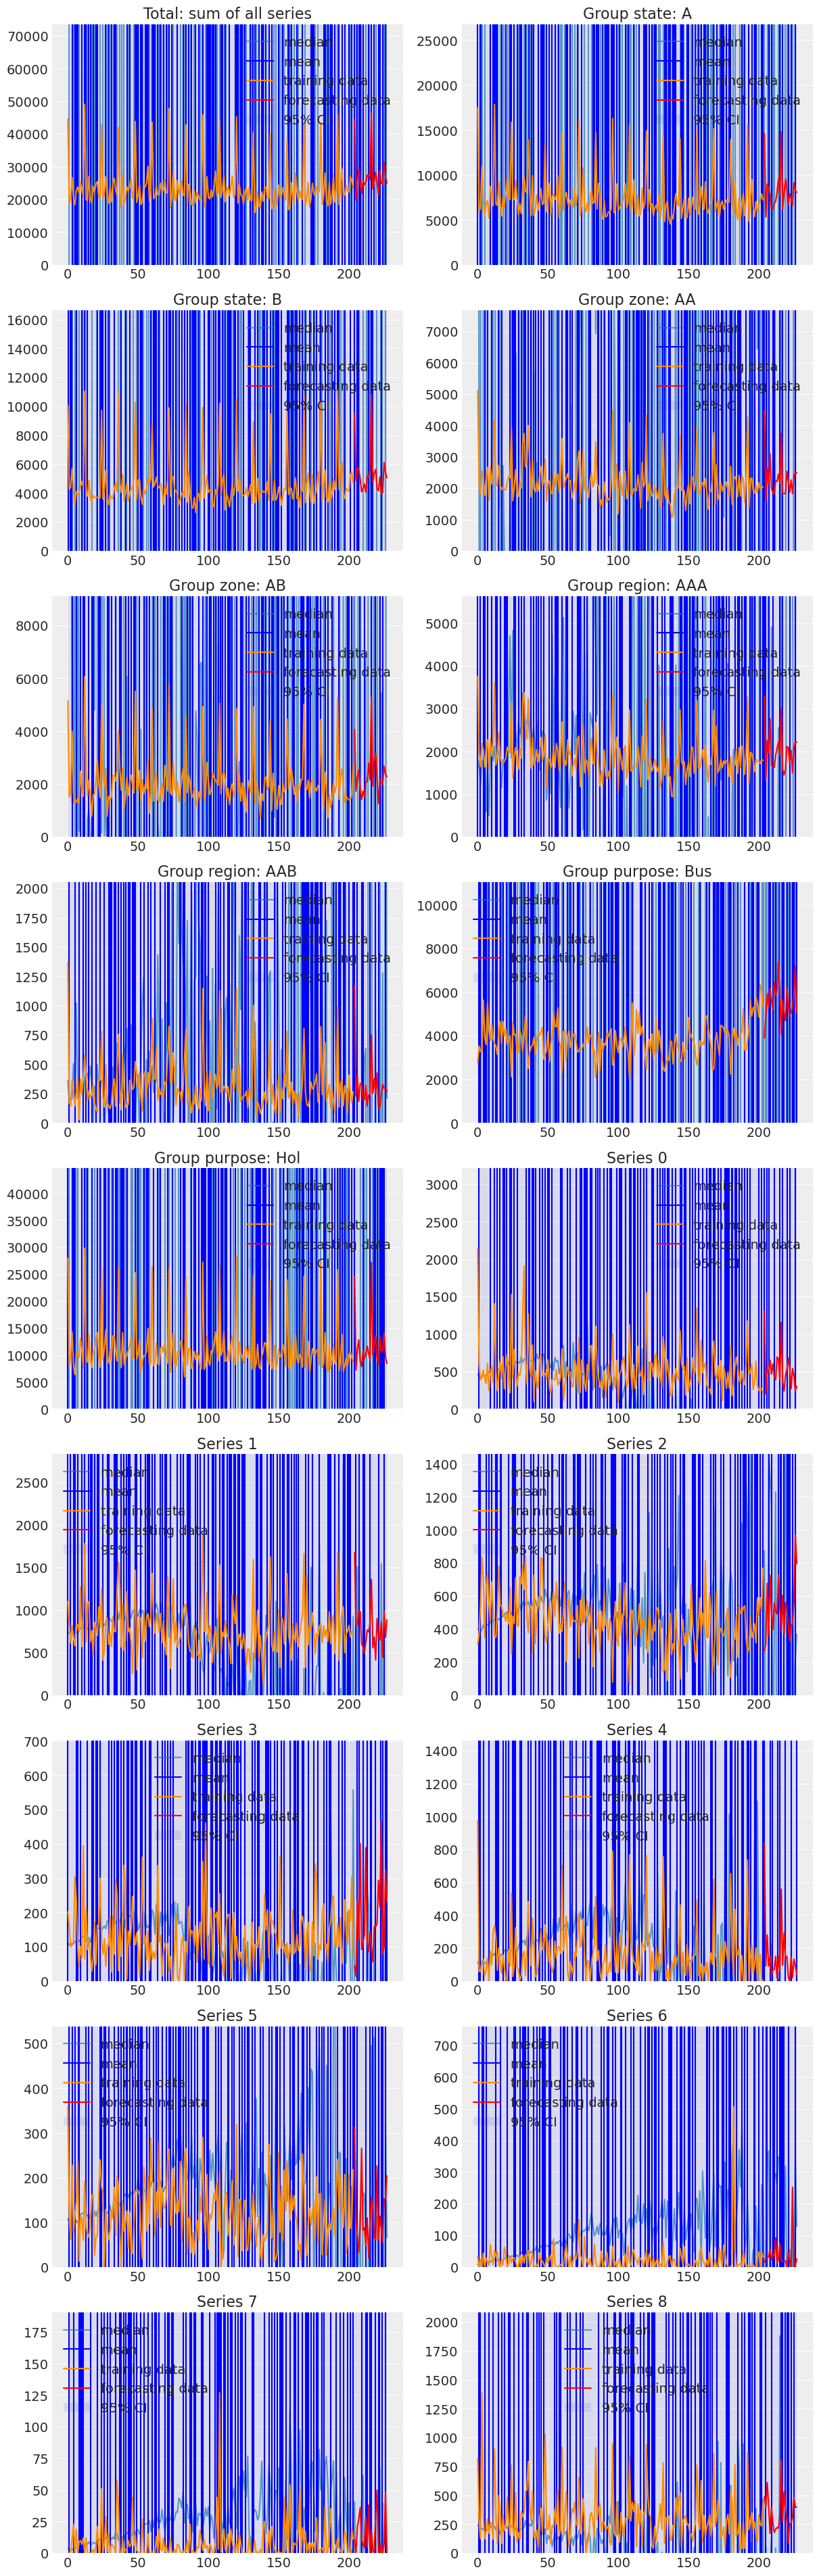

In [8]:
visualize_predict(groups, m.pred_samples_predict, 10)

In [9]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

,bottom,total,state,zone,region,purpose,all
mase,1.0024833680532868e+76,6.522986027334607e+76,8.077429775612945e+76,4.833836632632877e+76,3.3239206942740303e+76,2.488227516353007e+76,1.0918118900481303e+76
rmse,1.9264906395610847e+78,5.719962086998004e+80,8.36647363462506e+79,2.1690857571353916e+79,7.705962558244156e+78,1.4641328860551796e+80,1.1150919734386964e+79
